In [1]:
#!/usr/bin/env python2
import os
import sys
import argparse

import time
from distutils.dir_util import copy_tree

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import binary_crossentropy

from iterator import Iterator
import cnn_model as ae_model
import gan_model as gan_model

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline


_FLOATX = config.floatX


In [9]:
#Training hyper-parameters

weight_decay = 0
num_epochs = 500
max_patience = 100
SAVEPATH = 'save_models' 
LOADPATH = 'load_models'
batch_size = 250
extract_center = True
load_caption = False
#nb_discriminator_steps = 2

#Model Hyperparameters
conv_before_pool=[2,2,2]
n_filters = 32                      
code_size = 500
filter_size = 3
pool_factor = 2
output_nonlin = lasagne.nonlinearities.sigmoid #for the generator
with_dense_layer = True

#all_caps = True

#learning_rate_gen = 0.05
#learning_rate_discr = 0.0005
lambda_rec = 1.0
lambda_adv = 2.0#.05
clip_treshold = 0.02

all_image = True #whether to give the whole image or only the center to the discriminator

subset_train = 5
subset_valid = 5

In [10]:
learning_rate_gen =  theano.shared(np.array(0.05, dtype=theano.config.floatX))
learning_rate_discr =  theano.shared(np.array(0.05, dtype=theano.config.floatX))

In [11]:
#######################
# Saving path and stuff
######################

exp_name = 'nb_AEwgan_'#+ ('5' if all_caps else '1') + 'caps'
#exp_name += '_nonlin='+str(output_nonlinD)
exp_name += '_dense=' + str(with_dense_layer)
exp_name += '_lrG='+str(learning_rate_gen)
exp_name += '_lrD='+str(learning_rate_discr)
exp_name += '_lambREC=' +str(lambda_rec)
exp_name += '_lambADV='+str(lambda_adv)
exp_name += '_clip='+str(clip_treshold)
exp_name += '_wd='+str(weight_decay)
exp_name += '_bs='+str(batch_size)
exp_name += '_conv='+str(conv_before_pool)
exp_name += '_nfilt='+str(n_filters)
exp_name += '_code='+str(code_size)
exp_name += ('_subTRAIN'+str(subset_train)) if subset_train>0 else ''
exp_name += ('_subVALID'+str(subset_valid)) if subset_valid>0 else ''




savepath=os.path.join(sys.path[1],SAVEPATH, exp_name)
loadpath=os.path.join(sys.path[1],LOADPATH, exp_name)

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))
print 'Saving directory : ' + savepath
print 'Loading directory : '+ loadpath

Saving directory : /u/larocste/ift6266_project/save_models/nb_AEwgan__dense=True_lrG=<CudaNdarrayType(float32, scalar)>_lrD=<CudaNdarrayType(float32, scalar)>_lambREC=1.0_lambADV=2.0_clip=0.02_wd=0_bs=250_conv=[2, 2, 2]_nfilt=32_code=500_subTRAIN5_subVALID5
Loading directory : /u/larocste/ift6266_project/load_models/nb_AEwgan__dense=True_lrG=<CudaNdarrayType(float32, scalar)>_lrD=<CudaNdarrayType(float32, scalar)>_lambREC=1.0_lambADV=2.0_clip=0.02_wd=0_bs=250_conv=[2, 2, 2]_nfilt=32_code=500_subTRAIN5_subVALID5


In [12]:
#######################
#Build dataset iterator
#######################

print "Loading training data..." #threads???
train_iter = Iterator(which_set='train', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

print "Loading validation data..." #threads???
valid_iter = Iterator(which_set='valid', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

test_iter = None



n_batches_train = train_iter.n_batches
n_batches_valid = valid_iter.n_batches
n_batches_test = test_iter.n_batches if test_iter is not None else 0

print "Batch. train: %d, val %d, test %d" % (n_batches_train,
                            n_batches_valid, n_batches_test)

Loading training data...
Loading validation data...
Batch. train: 331, val 162, test 0


In [13]:
##########################################
# Build generator and discriminator models
##########################################
print('Defining symbolic variables and building models')

#Input and target var for the generator
ae_input_var = T.tensor4('input img bx3x64x64')
ae_captions_var = T.matrix('captions var')
ae_target_var = T.tensor4('target var bx3x32x32')



model = ae_model.AE_contour2center()

model.build_network(input_var = ae_input_var,
                  conv_before_pool=conv_before_pool,
                  with_dense_layer = with_dense_layer,
                  output_nonlin = output_nonlin,
                  n_filters = n_filters,
                  code_size = code_size,
                  filter_size = filter_size,
                  pool_factor = pool_factor)

print 'Done'


Defining symbolic variables and building models
Done


In [14]:
D = gan_model.discriminator()
D.build_network(input_var = ae_target_var, contour_var = ae_input_var, 
                all_image = all_image, conv_before_pool = [2,2,2,2])

D_over_G = gan_model.discriminator_over_generator()
D_over_G.build_network(G_net = model, D_net=D)

In [15]:
model.compile_theano_functions(learning_rate = learning_rate_gen, comp_train = False, comp_valid=False)

Defining and compiling get_imgs function
Done


In [16]:
#####################################
# Define and compile theano functions
#####################################

print "Defining and compiling theano functions"

pred_img = lasagne.layers.get_output(model.net)
rec_loss = model.get_loss(pred_img, ae_target_var)


D_predictions = lasagne.layers.get_output(D.net)
D_over_G_predictions = lasagne.layers.get_output(D_over_G.net)





print 'model.train_fn'

clip_penalty = T.mean( lasagne.objectives.squared_error(
                    lasagne.layers.get_output(model.dict_net['last_layer']),
                    lasagne.layers.get_output(model.dict_net['final_nonlin']) ) )

model_loss = lambda_rec*rec_loss - lambda_adv*T.mean(D_over_G_predictions) + 0.001*clip_penalty

ae_params = lasagne.layers.get_all_params(model.net, trainable=True)
ae_updates = lasagne.updates.rmsprop(model_loss, ae_params, learning_rate = learning_rate_gen)
# ae_updates = lasagne.updates.apply_nesterov_momentum(ae_updates, ae_params, momentum = 0.9)
model.train_fn = theano.function([ae_input_var, ae_target_var], model_loss, updates = ae_updates,
                            allow_input_downcast=True)



print 'D.train_fn'

D_loss = - T.mean(D_predictions -D_over_G_predictions)

D_params = lasagne.layers.get_all_params(D.net, trainable=True)
D_updates = lasagne.updates.rmsprop(D_loss, D_params, learning_rate=learning_rate_discr)
D.train_fn = theano.function([ae_input_var, ae_target_var], D_loss, updates=D_updates,
                            allow_input_downcast=True, on_unused_input='warn')

print 'Done'



Defining and compiling theano functions
model.train_fn
D.train_fn
Done


In [17]:
# valid_pred_imgs = lasagne.layers.get_output(model.net,deterministic=True)
# valid_loss = lambda_rec*model.get_loss(valid_pred_imgs, ae_target_var) - lambda_adv*T.mean(lasagne.layers.get_output(D_over_G.net))

# valid_fn = theano.function([ae_input_var, ae_target_var], valid_loss, allow_input_downcast=True)
# model.valid_fn = valid_fn

In [18]:
D.get_pred = theano.function([ae_input_var,  ae_target_var], D_predictions, on_unused_input='ignore')
D_over_G.get_pred = theano.function([ae_input_var, ae_target_var], D_over_G_predictions, on_unused_input='warn')

/part/01/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: target var bx3x32x32.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  from ipykernel import kernelapp as app


In [19]:
model.beforenonlin = theano.function([ae_input_var], lasagne.layers.get_output(model.dict_net['last_layer']))
model.afternonlin = theano.function([ae_input_var], lasagne.layers.get_output(model.dict_net['final_nonlin']))

In [20]:
D.beforenonlin = theano.function([ae_target_var, ae_input_var], lasagne.layers.get_output(D.dict_net['last_layer']),
                                on_unused_input='warn')
D_over_G.beforenonlin = theano.function([ae_input_var], lasagne.layers.get_output(D_over_G.dict_net['last_layer']))


In [21]:
plot_results_train = True
plot_results_valid = True


num_epochs = 200


In [22]:
# Initialization

err_train = []
err_D_train = []
err_valid = []

patience = 50

reset_best_results = True
subset_train = 50
subset_valid = 5

In [23]:
learning_rate_gen.set_value(0.001)
learning_rate_discr.set_value(0.0001)
    

Start training


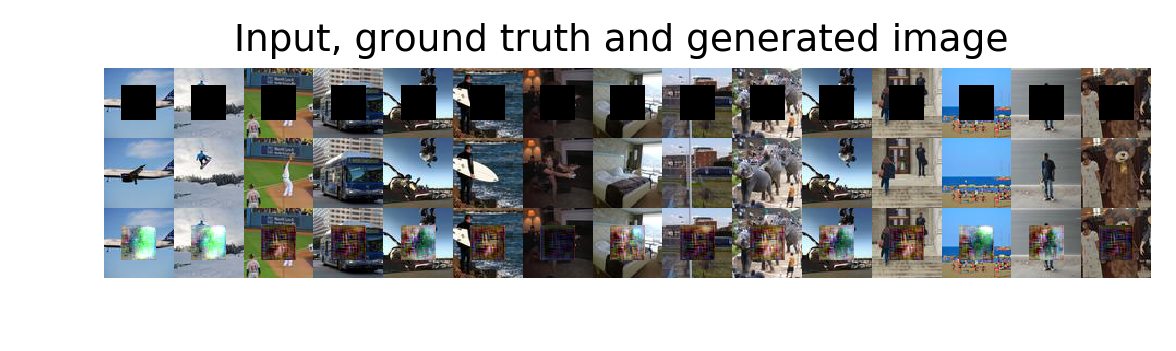

EPOCH 0: Avg cost train 0.266104, cost discr train -0.015515, cost val 0.000000, took 364.884507 s


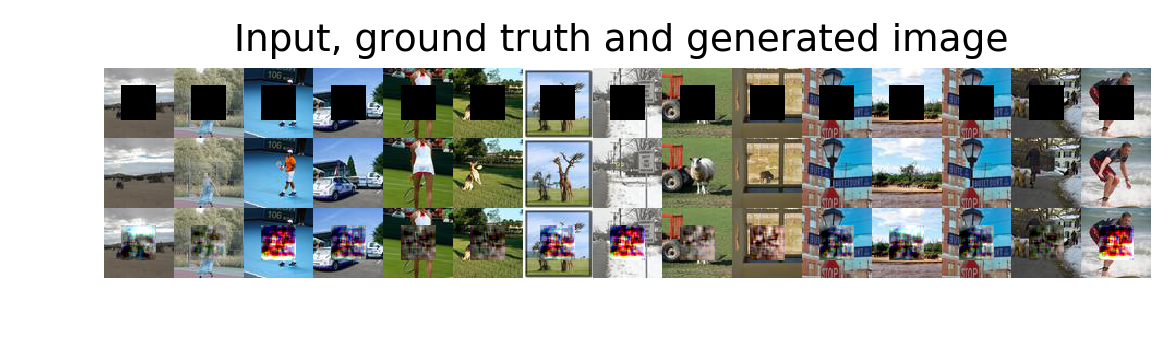

EPOCH 1: Avg cost train 0.339939, cost discr train -0.017952, cost val 0.000000, took 364.726876 s


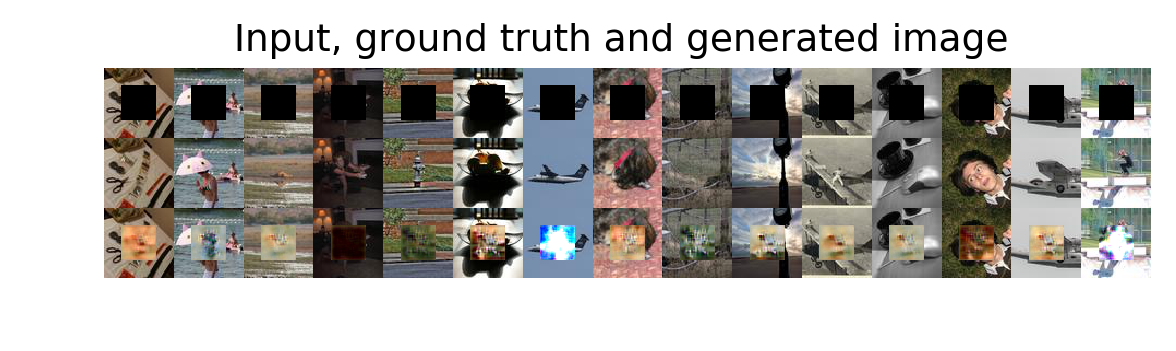

EPOCH 2: Avg cost train 0.662183, cost discr train -0.078389, cost val 0.000000, took 364.762945 s


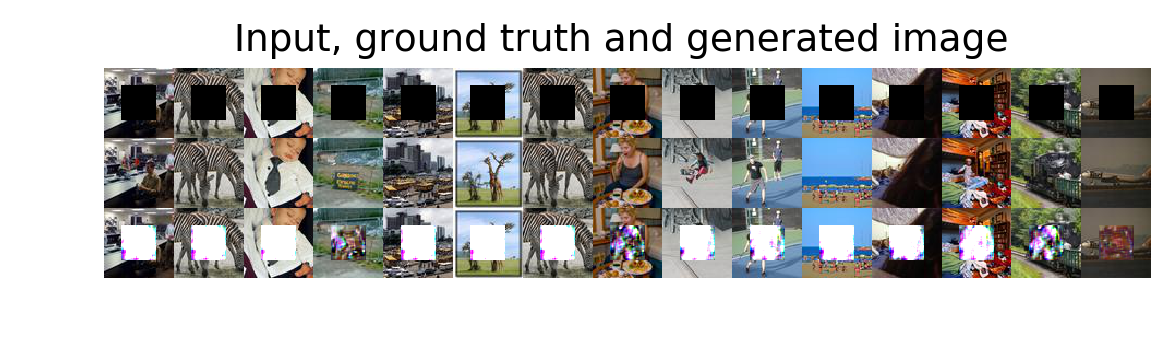

EPOCH 3: Avg cost train 1.628459, cost discr train -1.095212, cost val 0.000000, took 364.685988 s


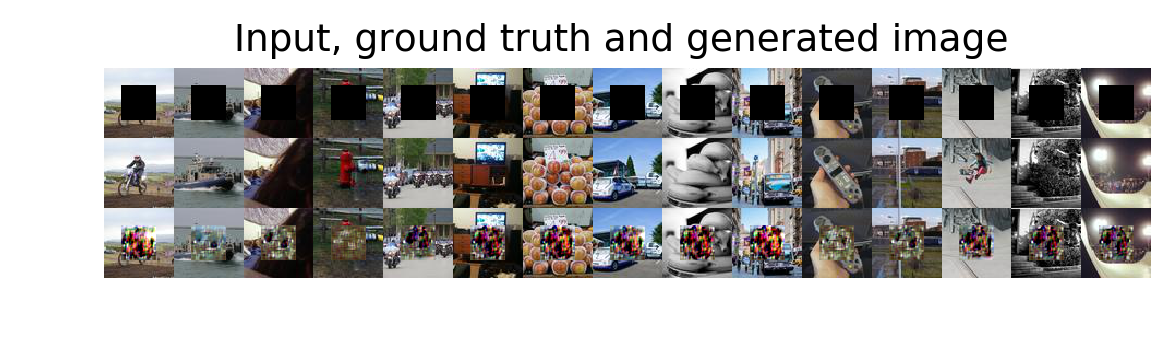

EPOCH 4: Avg cost train 2.606410, cost discr train -2.261711, cost val 0.000000, took 364.833367 s


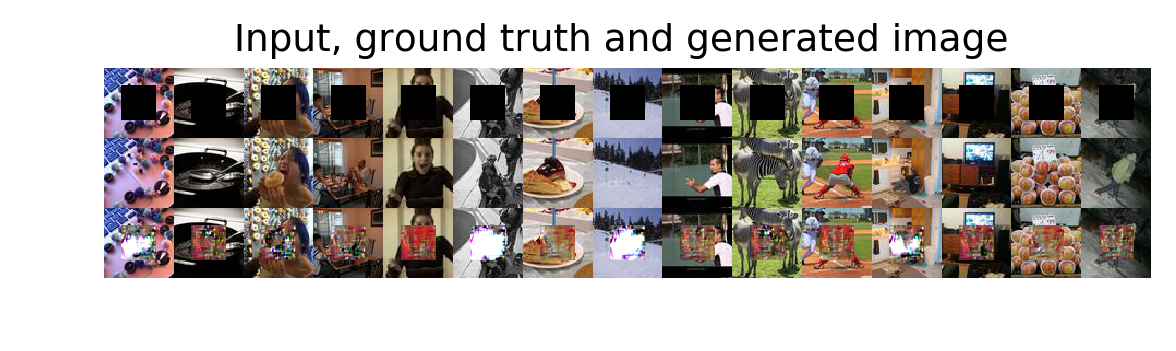

EPOCH 5: Avg cost train 3.187014, cost discr train -2.946710, cost val 0.000000, took 364.770380 s


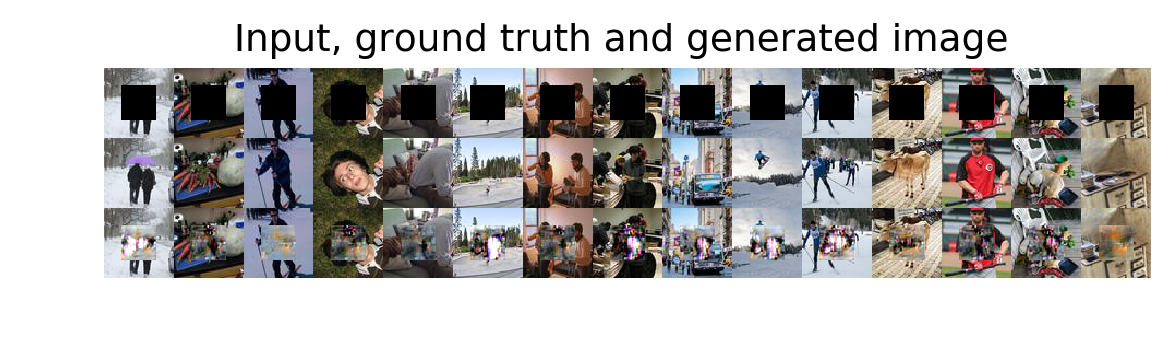

EPOCH 6: Avg cost train 3.607760, cost discr train -3.356038, cost val 0.000000, took 364.641662 s


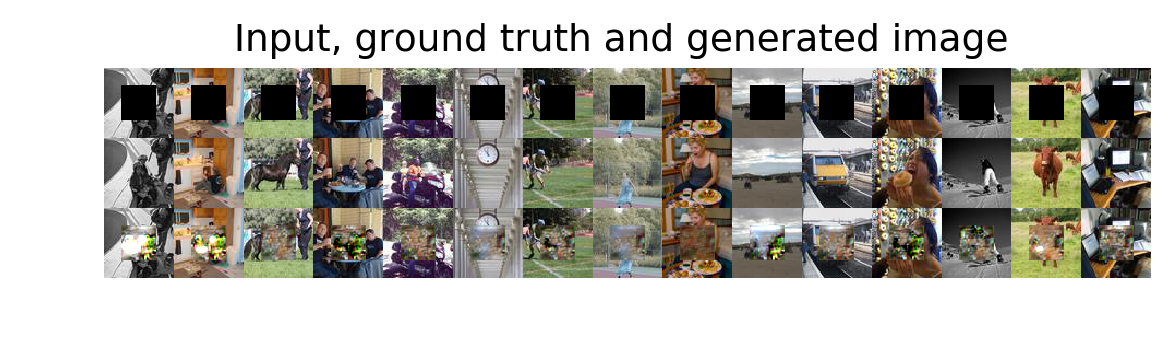

EPOCH 7: Avg cost train 3.859939, cost discr train -3.508542, cost val 0.000000, took 364.767677 s


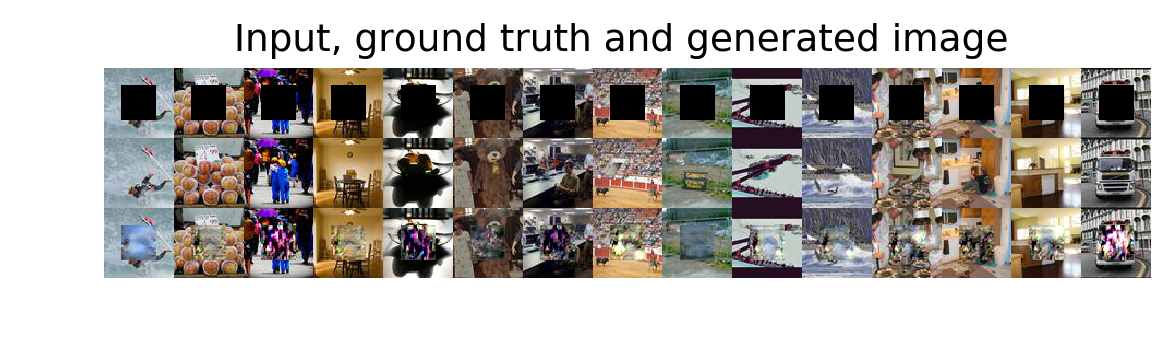

EPOCH 8: Avg cost train 4.180337, cost discr train -3.867787, cost val 0.000000, took 365.035273 s


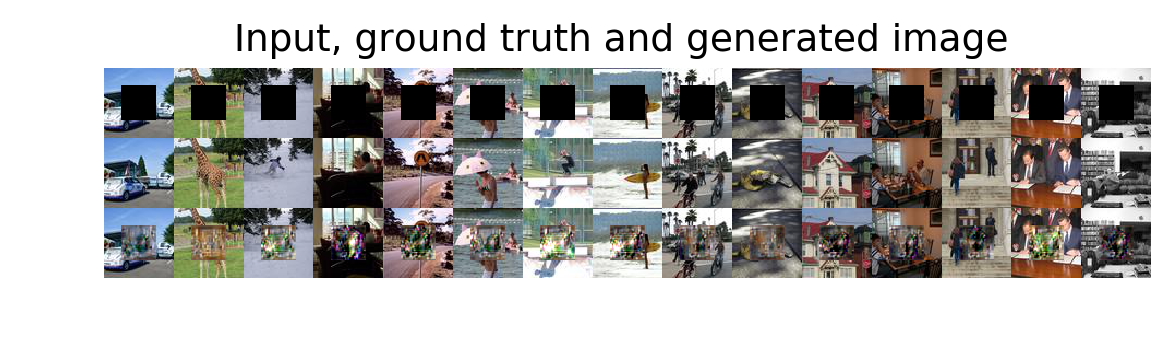

EPOCH 9: Avg cost train 4.286134, cost discr train -4.067879, cost val 0.000000, took 364.663944 s


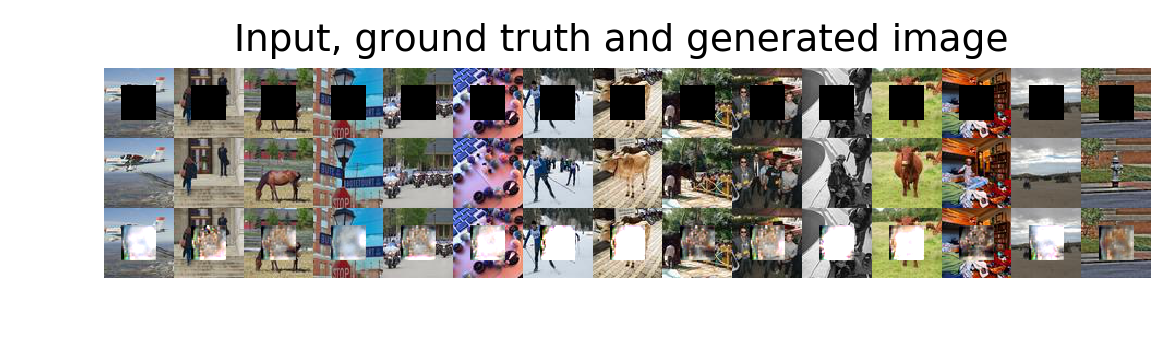

EPOCH 10: Avg cost train 4.400426, cost discr train -3.998115, cost val 0.000000, took 364.746724 s


KeyboardInterrupt: 

In [24]:
#
# Train loop
#



# Training main loop
print "Start training"

for epoch in range(num_epochs):
    learning_rate_gen.set_value((learning_rate_gen.get_value()*0.99).astype(theano.config.floatX))
    learning_rate_discr.set_value((learning_rate_discr.get_value()*0.99).astype(theano.config.floatX))
    
    
    start_time = time.time()
    cost_train_epoch = 0
    cost_D_epoch = 0
    
    # Train      
        
    for i, train_batch in enumerate(train_iter):
        
        if subset_train > 0 and i>= subset_train:
            break
          
        train_batch = model.extract_batch(train_batch)
        inputs_train, targets_train, caps_train = train_batch
        
 
        
        cost_D_batch = D.train_fn(inputs_train, targets_train)
        cost_D_epoch += cost_D_batch  
        
#         if i%5==0:
#             print 'difference avant non lin', np.mean(
#                 D.beforenonlin(targets_train, inputs_train)-D_over_G.beforenonlin(inputs_train) )

            
        #print 'D cost batch', i, cost_D_batch

        #DG_pred = D_over_G.get_pred(inputs_train,  targets_train)
        #idx_max = np.argmax(DG_pred)
        #idx_min = np.argmin(DG_pred)
        #print 'max', idx_max, DG_pred[idx_max], 'min', idx_min, DG_pred[idx_min]
        #print 'idx', idx, ' achieved ', DG_pred[idx]
        #model.compute_and_plot_results((inputs_train[idx:idx+1], targets_train[idx:idx+1], caps_train[idx:idx+1]), title='')

            
        
        #clip_treshold = 0.05
        all_params = lasagne.layers.get_all_param_values(D.net, trainable=True)
        n_params = len(all_params)
        new_params = np.array([np.clip(all_params[j], -clip_treshold, clip_treshold) for j in range(n_params)])


        lasagne.layers.set_all_param_values(D.net, new_params, trainable=True)
        
        #print model.beforenonlin(inputs_train)[0][:][32][32]
        
        
        
        #print 'diff avant G', np.mean(D.get_pred(inputs_train, targets_train) - D_over_G.get_pred(inputs_train, targets_train))

        cost_train_batch = model.train_fn(inputs_train, targets_train)
        cost_train_epoch += cost_train_batch
#             print 'difference avant non lin apres update G', np.mean(
#                 D.beforenonlin(targets_train, inputs_train)-D_over_G.beforenonlin(inputs_train) )
            

        #print 'diff apres G', np.mean(D.get_pred(inputs_train, targets_train) - D_over_G.get_pred(inputs_train, targets_train))
        
        #print 'ae cost batch ' , cost_train_batch
        
        #print 'before' , model.beforenonlin(inputs_train)[0][:,16,16]        
        #print 'after ' , model.afternonlin(inputs_train)[0][:,16,16]
        
     
    #print 'D pred', D.get_pred(inputs_train, targets_train)[:10]
    #print 'DG pred ', D_over_G.get_pred(inputs_train,  targets_train)[:10]
        #if i%5==0:
    if plot_results_train: #select random example from the last minibatch and plot it
        model.compute_and_plot_results(train_batch, title='')
#                 model.compute_and_plot_results((inputs_train[215:230], targets_train[215:230], caps_train[215:230]), 
#                                                title = '')
    
        
        
        
    #Add epoch results    
    err_train += [cost_train_epoch/subset_train]
    
    err_D_train += [cost_D_epoch/subset_train]
    
    

    # Validation
    cost_val_epoch = 0
    

#     for i, valid_batch in enumerate(valid_iter):
        
#         if subset_valid > 0 and i> subset_valid:
#             break
#         #rint 'valid', i

#         valid_batch = model.extract_batch(valid_batch)
#         inputs_valid, targets_valid, caps_valid = valid_batch

#         # Validation step
#         cost_val_batch = model.valid_fn(inputs_valid, targets_valid)
#         #print i, 'validation batch cost : ', cost_val_batch


#         #Update epoch results
#         cost_val_epoch += cost_val_batch
        
    
#     if plot_results_valid: #select random example from the last minibatch and plot it
#         model.compute_and_plot_results(valid_batch, title = 'VALID')
        
    #Add epoch results 
    err_valid += [cost_val_epoch/n_batches_valid]
    

    #Print results (once per epoch)
    out_str = "EPOCH %i: Avg cost train %f, cost discr train %f, cost val %f, took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         err_D_train[epoch],
                         err_valid[epoch],
                         time.time()-start_time)
    print out_str
   
    






In [64]:
np.min(inputs_train)

0.0

# auto_wgan_epi


- on train subset 50 minibatch of 1000 samples each
- 

- 0.001 with l_adv = 1
- 0.001 with l_adv = 5
- 0.0001 with l_adv = 5 .. no clipping
- added clipping to 0.1
- l_adv to 0.05
- remove clipping


- l_adv = 05, lr_dis = 0.0001, treshcol = 0.05
- lr_gen = 0.05

In [ ]:
#     Early stopping and saving stuff
    
    with open(os.path.join(savepath, "ae_output.log"), "a") as f:
        f.write(out_str + "\n")
        
    if epoch == 0 and reset_best_results:
        best_err_valid = err_valid[epoch]
    elif epoch > 1 and err_valid[epoch] < best_err_valid:
        print('saving best (and last) model')
        best_err_valid = err_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'ae_model_best.npz'),*lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_best.npz"), err_train=err_train, err_valid=err_valid)
        np.savez(os.path.join(savepath, 'ae_model_last.npz'), *lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"), err_train=err_train, err_valid=err_valid)
        
        np.savez(os.path.join(savepath, 'D_model_best.npz'),*lasagne.layers.get_all_param_values(D.net))
        np.savez(os.path.join(savepath, 'D_model_last.npz'), *lasagne.layers.get_all_param_values(D.net))
        
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'ae_model_last.npz'), *lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath, 'D_model_last.npz'), *lasagne.layers.get_all_param_values(D.net))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"), err_train=err_train, err_valid=err_valid)
        
    # Finish training if patience has expired or max nber of epochs reached
    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break 